In [19]:
from PIL import Image
import requests
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import torch
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

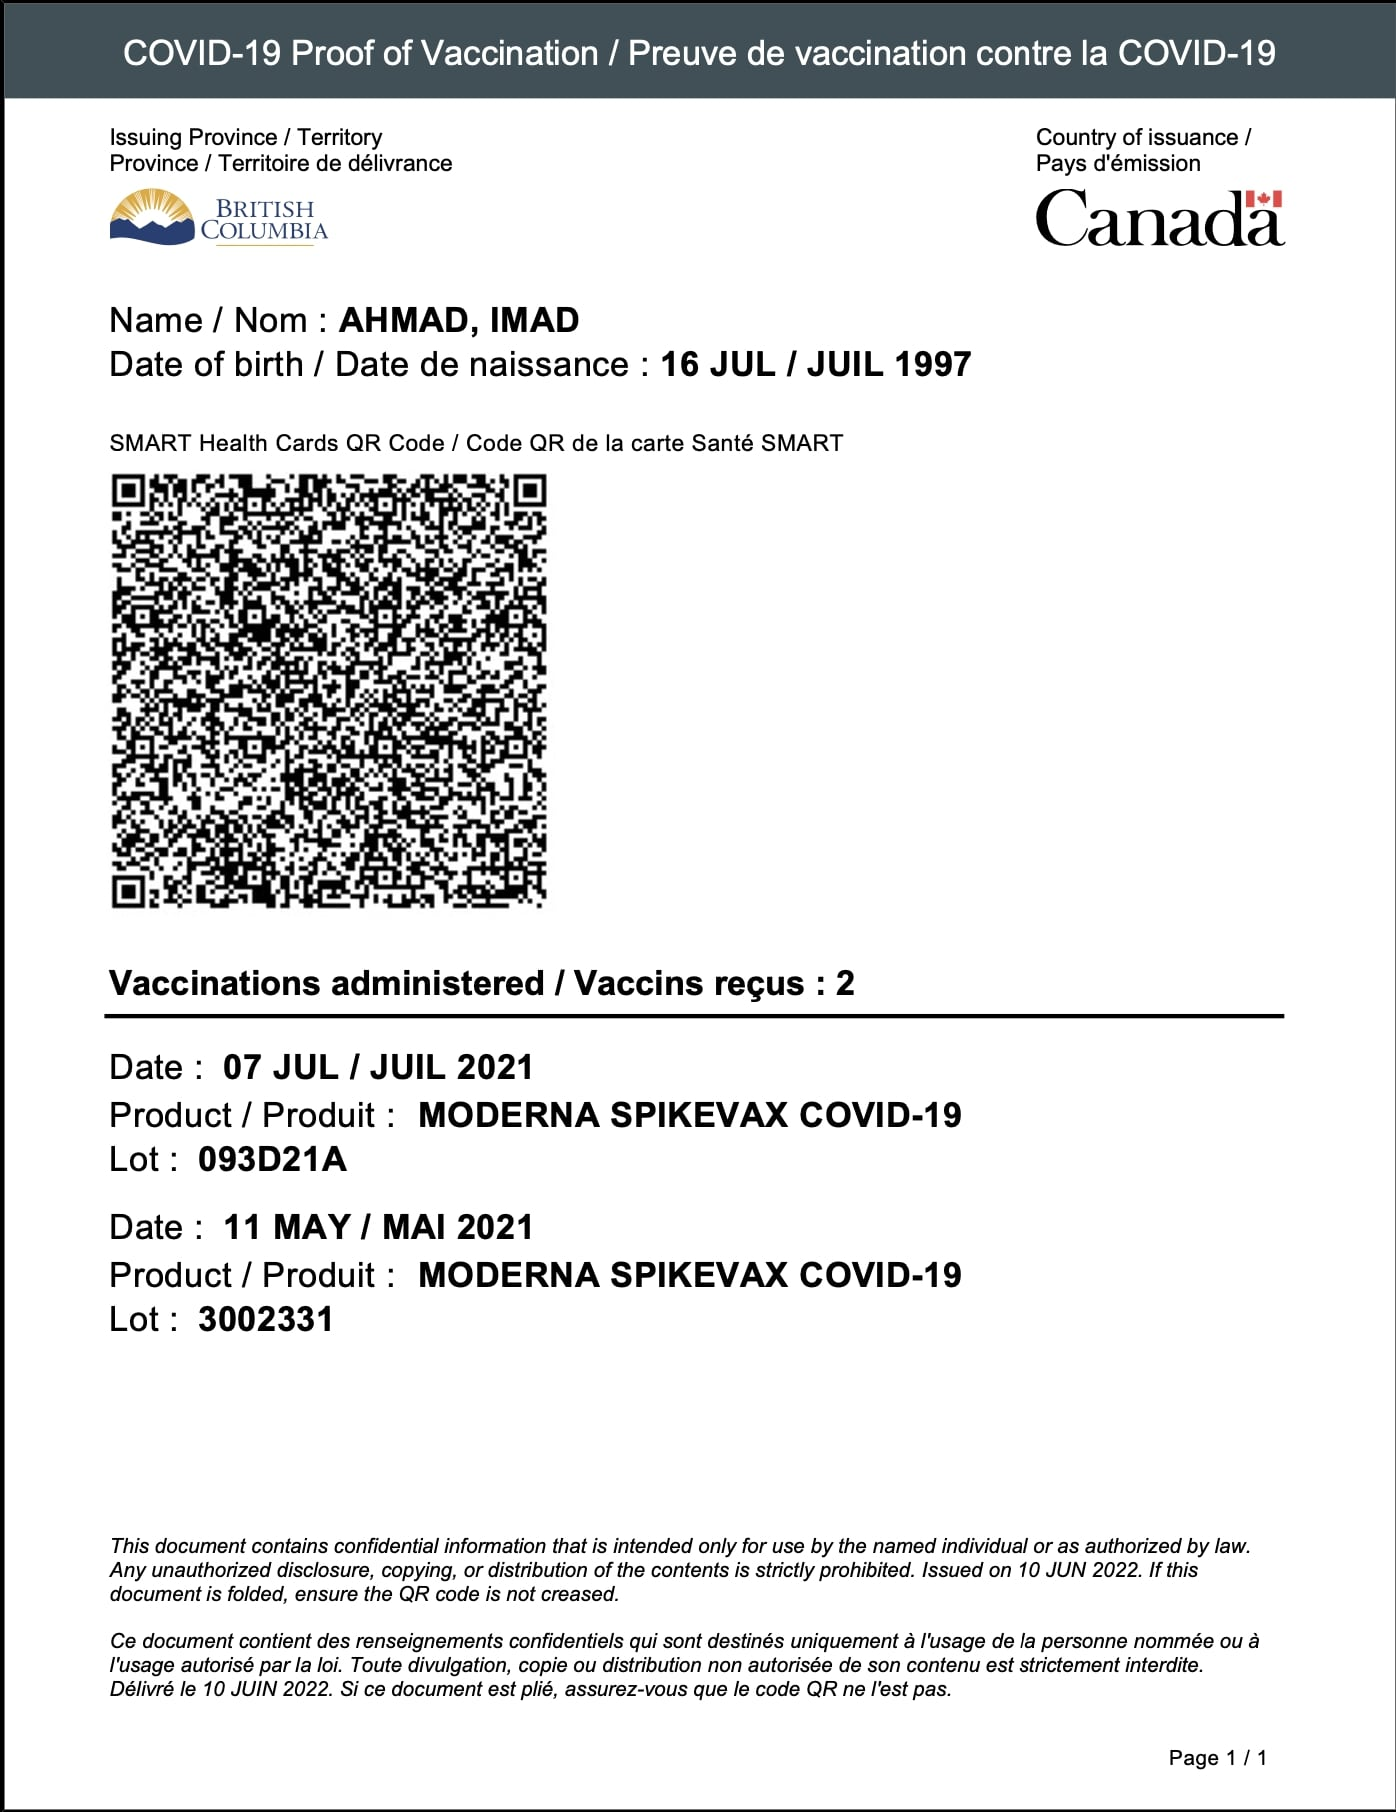

In [20]:
url = "test_data"
image = Image.open('test_data.jpg')
image

In [3]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [21]:
prompts = ["Name", "Date of Birth", "Lot", "QR Code"]

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")

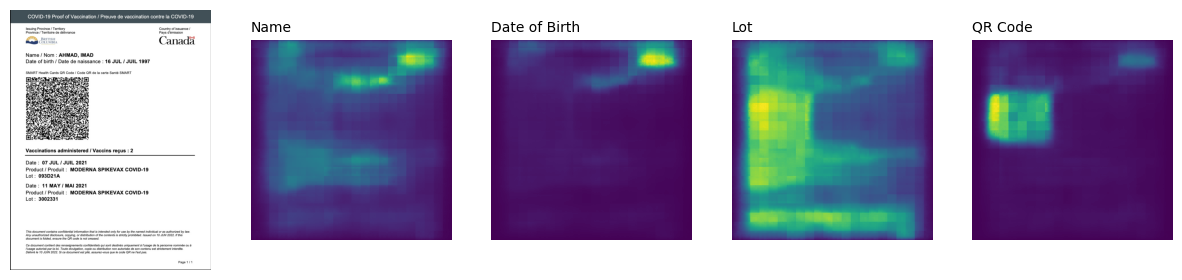

In [22]:

# predict
with torch.no_grad():
  outputs = model(**inputs)

preds = outputs.logits.unsqueeze(1)

# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(4)];
[ax[i+1].text(0, -15, prompts[i]) for i in range(4)];

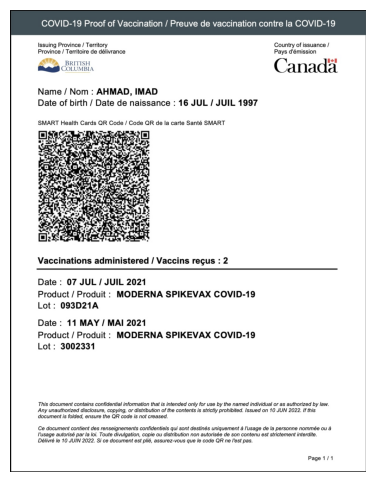

In [31]:
with torch.no_grad():
  outputs = model(**inputs)


preds = outputs.logits

# Process each prediction and draw bounding boxes
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)  # Display the original image
ax.axis('off')

for i in range(len(prompts)):
    # Convert logits to probabilities and create a binary mask
    prob = torch.sigmoid(preds[i][0])
    mask = prob > 0.5  # Threshold for binary segmentation

    # Find coordinates of the bounding box
    pos = torch.where(mask)
    if pos[0].nelement() != 0 and pos[1].nelement() != 0:
        xmin, xmax = min(pos[1]), max(pos[1])
        ymin, ymax = min(pos[0]), max(pos[0])
        width, height = xmax - xmin, ymax - ymin

        # Draw the bounding box
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 10, prompts[i], color='white', fontsize=8, backgroundcolor='red')

plt.show()